# Density estimation
Use powerball dataset

In [1]:
%matplotlib inline
import theano
import pymc3 as pm
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')
sns.set_style('white')
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
import theano.tensor as tt
import pandas as pd
import scipy as sp

## Load dataset
Peek into the data - curiosity helps build intuition
Intuition yields a prior (required for probabilistic modeling).


In [2]:
df = pd.read_csv('./pb/pb_asc_x1x5_x6.csv', header=None, names=['x1', 'x2', 'x3', 'x4', 'x5', 'x6'])
df.head()

,x1,x2,x3,x4,x5,x6
0,16,30,41,48,53,16
1,1,26,41,50,57,11
2,23,33,42,46,59,4
3,2,18,19,22,63,19
4,10,16,40,52,55,17


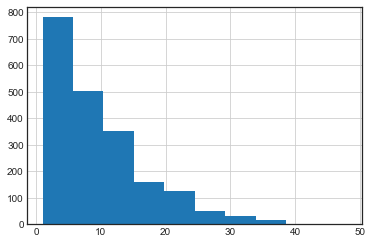

In [3]:
df['x1'].hist()

### The Model
Assume x1 is given for x2, and so on
For x1, we estimate the density and pick the MAP 

In [4]:
%%latex
\begin{align}
\alpha \sim \Gamma(1,1) \\
\beta_1...\beta_K \sim \beta(1, \alpha) \\
w_i = \beta_i \prod_{j=1}^{i-1}(1-\beta_j) \\
a_i \sim U(0,50) \\
b_i \sim U(0,50) \\
\lambda_i = a_i * x_1 + b_i \\
x_2 \sim \sum_{}^{}w_i Pois(\lambda_i)\\
\end{align}

<IPython.core.display.Latex object>

In [5]:
SEED=5132290
K = 30
#x1 = df['x1'].values
def stick_breaking(beta):
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1-beta)[:-1]])
    return beta * portion_remaining


In [6]:

with pm.Model() as model:
    alpha = pm.Gamma('alpha', 1,1)
    beta = pm.Beta('beta', 1, alpha, shape=K)
    w = pm.Deterministic('w', stick_breaking(beta))
    #a = pm.Uniform('a', 0, 50, shape=K)
    #b = pm.Uniform('b', 0, 50, shape=K)
    mu = pm.Uniform('mu', 0, 50, shape=K)
    #bp = pm.Bound(pm.Poisson, lower=1)('bp', mu=mu)
    x = pm.Mixture('obs', w, pm.Poisson.dist(mu), observed=df['x1'].values)


In [7]:
with model:
    trace = pm.sample(1000, random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [45:13<00:00,  1.81s/it]


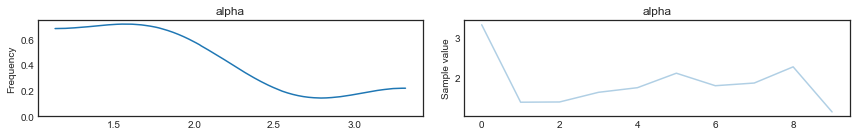

In [124]:
with model:
    pm.traceplot(trace, varnames=['alpha'])

Text(0,0.5,'Mixture weight')

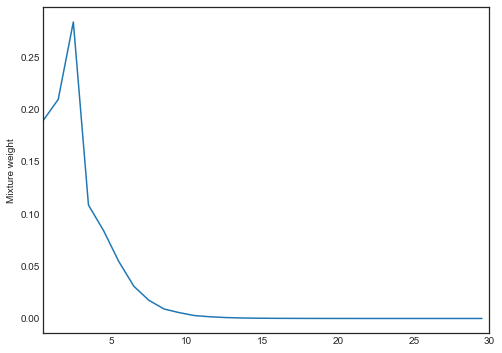

In [54]:
plot_w = np.arange(K) + 1
fig, ax = plt.subplots(figsize=(8,6))
#ax.hist(df['x2'].values, alpha=0.2, color='blue', normed=True)
ax.plot(plot_w-0.5, trace['w'].mean(axis=0) )
ax.set_xlim(.5, K)
ax.set_ylabel('Mixture weight')

In [80]:
x_plot = np.arange(50) #Range of values of x1
#Create the set of Poisson distributions with means 'mu'
pmf_contribs = sp.stats.poisson.pmf(np.atleast_3d(x_plot), trace['mu'][:, np.newaxis, :])

#Multiply each distribution by its weight
wt_pmfs = (trace['w'][:, np.newaxis, :] * pmf_contribs).sum(axis=-1)
#trace['mu'].shape, x_plot.shape,np.atleast_3d(x_plot).shape, pmf_contribs.shape, pmfs.shape
wt_pmfs.shape, trace['mu'].shape, wt_pmfs[::200].shape, pmf_contribs.mean(axis=1).shape

((500, 50), (500, 30), (3, 50), (500, 30))

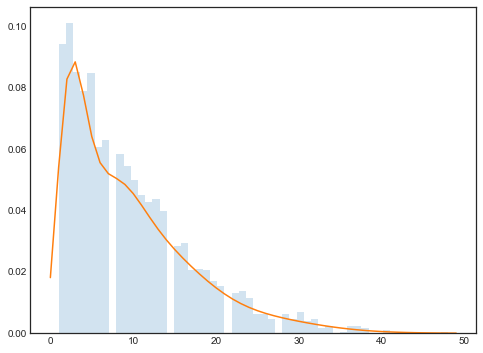

In [72]:
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(df['x1'].values, bins=54, alpha=0.2,normed=True)
#ax.plot(x_plot, wt_pmfs[0])
ax.plot(x_plot, wt_pmfs.mean(axis=0))
#ax.plot(x_plot, wt_pmfs[::200].T, color='orange')

In [86]:
pmf_contribs.mean(axis=1).shape, wt_pmfs.mean(axis=1).shape, trace['mu'].shape

((500, 30), (500,), (500, 30))

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 417.31it/s]


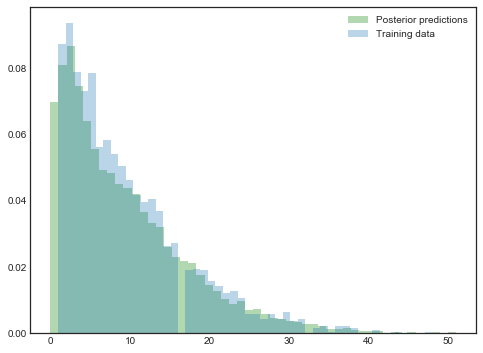

In [108]:
with model:
    ppc = pm.sample_ppc(trace, 10000)
    fig, ax = plt.subplots(figsize=(8,6))
    ax.hist(ppc['obs'], bins=50, normed=True, alpha=0.3, color='green', label='Posterior predictions')
    ax.hist(df['x1'], bins=50, normed=True, alpha=0.3, label='Training data')
    ax.legend(loc=1)

In [106]:
ppc['obs'].shape, df['x1'].shape

((5000,), (2022,))

In [109]:
from scipy.stats import wasserstein_distance, energy_distance 
energy_distance(ppc['obs'], df['x1']), wasserstein_distance(ppc['obs'], df['x1'])

(0.050563309473876605, 0.15680603363006945)

### Trials and tribulations
Do a conda install pydot, graphviz
Then, Add the path to dot.exe under graphviz (under Anaconda) to your system PATH variable
Then the following SVG call might work

<TensorType(float64, scalar)>
<TensorType(float64, scalar)> [id A]
Elemwise{add,no_inplace} [id A] ''   
 |Elemwise{mul,no_inplace} [id B] ''   
 | |TensorConstant{3} [id C]
 | |Elemwise{pow,no_inplace} [id D] ''   
 |   |<TensorType(float64, scalar)> [id E]
 |   |TensorConstant{2} [id F]
 |TensorConstant{1} [id G]


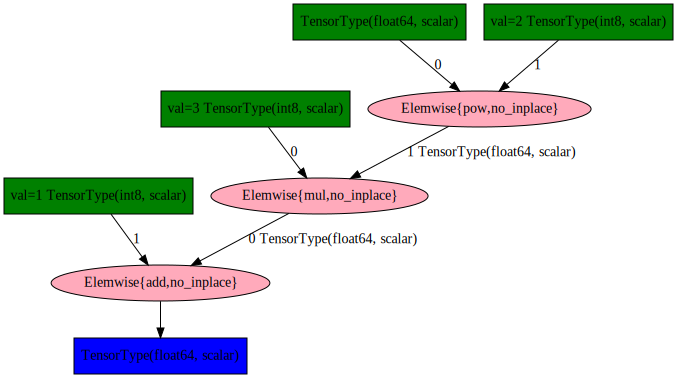

In [9]:
import pydot, theano
ax = theano.tensor.scalar()
print(ax)
theano.pprint(ax)
theano.printing.debugprint(ax)
from IPython.display import SVG
SVG(theano.printing.pydotprint(ax, return_image=True, format='svg'))

ay = 3*(ax**2) + 1
ay.eval({ax : 1})
theano.pprint(ay)
theano.printing.debugprint(ay)
SVG(theano.printing.pydotprint(ay, return_image=True, format='svg'))


In [ ]:
from sklearn.model_selection import train_test_split
df = df.sample(frac=1).reset_index(drop=True)
X_train, X_test, y_train, y_test = train_test_split(df['x6'], df['x1'], test_size=0.1)
X_train = np.reshape(X_train, (-1, 1))
y_train = np.reshape(y_train, (-1, 1))
X_test = np.reshape(X_test, (-1,1))
y_test = np.reshape(y_test, (-1, 1)) 

X_train, y_train, X_test, y_test

In [ ]:
fig, ax = plt.subplots(9, 5, figsize=(12, 20), sharey=True)
for i in range(0, 42):
    sns.distplot(df.loc[df['x6']==i+1]['x1'], ax=ax[i//5, i%5])


In [ ]:
rf_reg = RandomForestRegressor(max_depth=10, n_estimators=20)
rf_reg.fit(X_train, y_train)
y_ = np.round(rf_reg.predict(X_test))
y_ = np.reshape(y_, (-1, 1))
y_.shape, X_test.shape, y_test.shape, X_train.shape, y_train.shape, 


In [ ]:
#Within an epsilon distance
epsilon = 1
sum(np.sum((abs(y_ - y_test) <= epsilon), axis=1)) * 100./y_.shape[0]

In [ ]:
X_train.max(), X_train.min(), y_train.max(), y_train.min()

### Log transformed in and out
Transform x6 and x1 by np.log

In [ ]:
X_train, y_train, X_test, y_test = np.log(X_train), np.log(y_train), \
    np.log(X_test), np.log(y_test)
    

In [ ]:
sns.distplot(y_train)

In [ ]:
y_train.min()
#sns.distplot(np.log(y_train))

In [ ]:

rf_reg = RandomForestRegressor(max_depth=10, n_estimators=200)
rf_reg.fit(X_train, y_train)
y_ = rf_reg.predict(X_test)
y_ = np.reshape(y_, (-1, 1))
#y_.shape, X_test.shape, y_test.shape, X_train.shape, y_train.shape, 


In [ ]:
import math
#Within an epsilon distance
epsilon = math.e
sum(np.sum((abs(y_ - y_test) <= epsilon), axis=1)) * 100./y_.shape[0]

In [ ]:
sns.distplot(np.exp(y_), color='b')
sns.distplot(np.exp(y_test))

In [ ]:
#np.sqrt(np.sum(np.sum((y_ - y_test)**2, axis=1)))
#np.sum((y_ - y_test)**2, axis=1)
np.mean(y_ - y_test), np.var(y_ - y_test), np.max(y_ - y_test), np.min(y_ - y_test)

### Prepare the data
Training data consists of X1, X2 pairs
Also split the data into train and test

In [ ]:
from sklearn.cross_validation import train_test_split
def prepare_data(df):
    X_data = df[['x1', 'x2']]
    
    #Shuffle
    X_data = X_data.sample(frac=1).reset_index(drop=True)

    #split - train, test
    X_train, X_test, y_train, y_test = train_test_split(X_data['x1'], X_data['x2'], test_size=0.01)
    X_train = np.reshape(X_train, (-1, 1))
    X_test = np.reshape(X_test, (-1, 1))
    y_train = np.reshape(y_train, (-1, 1))
    y_test = np.reshape(y_test, (-1, 1))
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = prepare_data(df_train)

### Plot the training data (X2)

In [ ]:
fig, ax = plt.subplots()
ax.scatter(X_train, y_train, color='g', alpha=0.3)
plt.xlabel('X1'); plt.ylabel('X2')

_This makes sense of course, since X2 >= X1_

In [ ]:
sns.distplot(y_train)
plt.legend()


In [ ]:
xrange = np.arange(X_train.min(), X_train.max() + 1)
fig, ax = plt.subplots()
ax.plot(X_train[arange])

### Define a model for X2
Assuming BetaBinomial, discrete distribution with support over positive integers
The model for X2 will be a Bayesian Neural Net conditioned on the value of X1
The prior for the X2's support \{0..n\}  and it's alpha and beta are dependent on X1

In [ ]:
ntrain = len(X_train)

#Construct the NN
def construct_nn(nn_in, nn_out):
    n_hidden = 5
    init_1 = np.random.randn(1, n_hidden).astype(theano.config.floatX)
    init_2 = np.random.randn(n_hidden, n_hidden).astype(theano.config.floatX)
    init_3 = np.random.randn(n_hidden, 1).astype(theano.config.floatX)
    
    with pm.Model() as bnn:
        a = pm.Uniform('a', lower=0.4, upper=5.)
        b = pm.Uniform('b', lower=2., upper=8.)
        c = pm.Uniform('c', lower=1., upper=60.)
        
        weights_1 = pm.Normal('w_1', mu=0, sd=1, shape=(1, n_hidden), testval=init_1)
        weights_2 = pm.Normal('w_2', mu=0, sd=1, shape=(n_hidden, n_hidden), testval=init_2)
        weights_3 = pm.Normal('w_3', mu=0, sd=1, shape=(n_hidden, 1), testval=init_3)
        
        #Activations
        act_1 = pm.math.tanh(pm.math.dot(nn_in, weights_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1, weights_2))
        act_3 = pm.math.sigmoid(pm.math.dot(act_2, weights_3))
        
        print("{}, {}, {},".format(act_3.tag.test_value.shape, act_3.shape, type(act_3)))
        print("{}".format(act_3.tag.test_value[:,0].mean()))
#         print("{}".format(act_3.tag.test_value[:,1].mean()))
#         print("{}".format(act_3.tag.test_value[:,2].mean()))
#         a = pm.Deterministic('a', act_3.tag.test_value[:,0].mean())
#         b = pm.Deterministic('b', act_3.tag.test_value[:,1].mean())
#         c = pm.Deterministic('c', act_3.tag.test_value[:,2].mean())
        out = pm.BetaBinomial('x2pred', 
                              alpha=a, 
                              beta=b,
                              n=tt.round(c),
                              observed=nn_out, 
                              total_size=ntrain)
        
    return bnn

### Fit the model to data (Inference)
Uses ADVI to compute the posterior distribution of parameters

In [ ]:
nn_in = theano.shared(X_train)
nn_out = theano.shared(y_train)
bnn = construct_nn(nn_in, nn_out)
with bnn:
    # inference = pm.ADVI()
    approx = pm.sample(1000)

In [ ]:
with bnn:
    pm.plot_posterior(approx)


# Miscellaneous
## A Zero Truncated Poisson
__Custom Probability Distribution in PyMC3__

In [ ]:
import theano.tensor as tt
from theano import function
from theano import printing
import pymc3 as pm

class ZeroTruncatedPoisson(pm.Discrete):
    '''
    Similar to a Poisson distribution, but the support is over positive integes 
    and so, excludes zero. An example, number of items in your grocery shopping cart
    at checkout
    '''
    def __init__(self, mu, *args, **kwargs):
        super(ZeroTruncatedPoisson, self).__init__(*args, **kwargs)
        self.mu = tt.as_tensor_variable(mu)
    
    def logp(self, value):
        '''
        compute total_log_probability
        '''
        return tt.sum(value * tt.log(self.mu) - tt.log(tt.exp(self.mu) -1) - tt.gammaln(value))
    
    def random(self, point=None, size=None):
        '''
        Generates a random sample from Zero Truncated Poisson
        '''
        k = 1
        mu = self.mu.tag.test_value
        t = tt.exp(-self.mu)/(1 - tt.exp(-self.mu))/(1. * self.mu)
        tn = t.tag.test_value
        s = tn
        u = np.random.uniform()
        while s < u:
            k = k + 1
            tn = tn * mu / k
            s = s + tn
            u = np.random.uniform()
        return k

In [ ]:
# If using a ZeroTruncatedPoisson
# obs = df_train['x1']
# with pm.Model() as zmodel:
#     mu = pm.HalfNormal('mu', sd=10.)
#     zp_poisson = ZeroTruncatedPoisson('zp', mu=mu, observed=obs)
#     ztrace = pm.sample(1000)
#     pm.plot_posterior(ztrace)


In [ ]:
import numpy as np
import theano.tensor as tt
from theano import function
#tt.config.compute_test_value = 
x = tt.dscalar('x')
y = tt.dscalar('y')
z = x + y
tt.pprint(z)
add = function([x, y], z)
n1 = add(402., 1)
type(n1)
#n1
with pm.Model() as mmodel:
    a1 = 
    w1 = pm.Normal('w1', mu=0., sd=1., shape=(1, 2))
    a2 = pm.math.dot(a1, w1)


In [ ]:
k = np.array([1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,48,1])
import theano.tensor as tt
def ztp_logp(k):
    return tt.sum(k * tt.log(lam) - tt.log(tt.exp(lam) - 1) - tt.gammaln(k))

ztp_logp(k)


In [ ]:
vm1 = np.random.randn(1, 5).astype(theano.config.floatX)
type(vm1)
#vm1.shape
vm2= halfnorm.rvs(size=(1,5)).astype(theano.config.floatX)
type(vm2)
vm2.shape
X_train[0].shape
nn_in.shape


### Define the neural network

### Plot the posterior parameter distribution from 5000 samples

In [ ]:
with bnn:
    trace = approx.sample(draws=5000)
    pm.traceplot(trace)

### Plot the learnt boundary against training data

In [ ]:
with bnn:
    rpc = pm.sample_ppc(trace, 500)
    rpred = rpc['Category'].mean(axis=0)
    #rproba = rpc['Category'].std(axis=0)
    fig, ax = plt.subplots()
    ax.scatter(X_train[rpred > 0.5], rpred[rpred > 0.5], color='b', alpha=0.01)
    ax.scatter(X_train[rpred <= 0.5], rpred[rpred <= 0.5], color='r', alpha=0.01)
    ax.scatter(X_train[y_train], y_train[y_train], color='g', alpha=0.01)
    ax.scatter(X_train[~y_train], y_train[~y_train], color='k', alpha=0.01)

#### Plot the Evidence Lower Bound (ELBO) maximization history

In [ ]:
with bnn:
    plt.plot(-inference.hist, label='ADVI', color='b', alpha=0.4)
    plt.xlabel('Iteration')
    plt.ylabel('ELBO')

**__What is the functional form of the neural net?__**
<p>
The neural net computes the probability parameter of a Bernoulli distribution based on a series of non-linearities and affine transformations of the input

In [ ]:
bnn.Category.distribution

### Now time to predict (Posterior Predictive Check) 

In [ ]:
nn_in.set_value(X_test)
nn_out.set_value(y_test)
with bnn:
    ppc = pm.sample_ppc(trace, 500)
    pred = ppc['Category'].mean(axis=0)
    proba = ppc['Category'].std(axis=0)

### Plot the predictions

In [ ]:
fig, ax = plt.subplots()
ax.scatter(X_test[pred > 0.5], pred[pred > 0.5])
ax.scatter(X_test[pred <= 0.5], pred[pred <= 0.5], color='r', alpha=0.2)
ax.scatter(X_test[y_test], y_test[y_test], color='c', alpha=0.1)
ax.scatter(X_test[~y_test], y_test[~y_test], color='c', alpha=0.1)

print('Accuracy: {}'.format( ( y_test == (pred > 0.5) ).mean() * 100 ))

### Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
cm = [ 1 if x > 0.5 else 0 for x in pred ]
cnf = confusion_matrix(cm, y_test)
sns.heatmap(cnf, annot=True, fmt='d', cmap='PiYG')

In [ ]:
cnf

### Now the uncertainty in prediction

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.errorbar(X_test[pred > 0.5], pred[pred > 0.5], yerr = proba[pred > 0.5], fmt='o', ecolor='g', capthick=2, alpha=0.1)
ax.errorbar(X_test[pred <= 0.5], pred[pred <= 0.5], yerr = proba[pred <= 0.5], 
            fmt='o', ecolor='r', color='y', capthick=2, alpha=0.1)

## Comparison to a Gaussian Process classifier

In [ ]:
%%time
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

gp_clf = GaussianProcessClassifier(1.0 * RBF(1.0))
nsize=1000
gp_clf.fit(X_train[:nsize,:], y_train[:nsize,:])
#clf.fit(X_train, y_train)

**__Phew.... that took for ever. Especially in comparison to BNN__**

In [ ]:
%%time
print gp_clf.score(X_test, y_test)
xx = np.arange(1,70)
pp = gp_clf.predict_proba(xx.reshape(-1,1))
fig, ax = plt.subplots()
ax.scatter(xx, pp[:,1], color='r')

## Compare to a random forest classifier

In [ ]:
%%time
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
rf_clf.fit(X_train, y_train)

In [ ]:
%%time
print (rf_clf.score(X_test, y_test))
xx = np.arange(1,70)
pp = rf_clf.predict_proba(xx.reshape(-1,1))
fig, ax = plt.subplots()
ax.scatter(xx, pp[:,1], color='r')

## Compare to AdaBoosted Decision Trees

In [ ]:
%%time
from sklearn.ensemble import AdaBoostClassifier
ad_clf = AdaBoostClassifier()
ad_clf.fit(X_train, y_train)

In [ ]:
%%time
print (ad_clf.score(X_test, y_test))
xx = np.arange(1, 70)
pp = ad_clf.predict_proba(xx.reshape(-1,1))
fig, ax = plt.subplots()
ax.scatter(xx, pp[:,1], color='r')

## Miscellaneous

In [ ]:
with pm.Model():
    bs = pm.BetaBinomial('betasample', alpha=3., beta=4., n=50)
    bstrace = pm.sample(10000)
    pm.plot_posterior(bstrace)

In [ ]:
sns.distplot(df_train['x6'])